# Beta Bank 

Beta Bank customers are leaving: little by little, chipping away every month. The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones.

We need to predict whether a customer will leave the bank soon. We have the data on clients’ past behavior and termination of contracts with the bank.

Build a model with the maximum possible F1 score. To pass the project, we need an F1 score of at least 0.59. Check the F1 for the test set.

Additionally, measure the AUC-ROC metric and compare it with the F1.

## Preparation 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier

In [2]:
df = pd.read_csv('C:/Users/Kayo/Downloads/Churn.csv')

In [3]:
# Checking general DF info
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [29]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.998900,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,0.250900,0.247700,0.545700
std,96.653299,10.487806,2.784982,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,0.433553,0.431698,0.497932
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,0.000000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,0.000000,1.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000,0.000000,1.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
# Dropping useless columns
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [6]:
# OHE
df = pd.get_dummies(df, drop_first=True)
df.rename(columns={'Gender_Male':'Gender'}, inplace=True)

In [7]:
# Checking OHE worked properly
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [8]:
# Replacing NaN with KNN Imputer
imputer = KNNImputer()
df_convert = imputer.fit_transform(df)
df = pd.DataFrame(df_convert, columns=df.columns)

In [9]:
# Rechecking NaN count
print('Total amount of NaNs:', df.isna().sum().sum())

Total amount of NaNs: 0


In [10]:
# Dropping duplicate rows
print('Total amount of duplicates:', len(df.drop_duplicates()) - len(df))

Total amount of duplicates: 0


We dropped unneeded columns, prepared our columns using panda's one hot encoding method, and imputed away our NaNs using KNNImputer.

## Building Model

In [11]:
# Building our training and test data sets
# We use GridSearchCV so a validation set isn't needed
features_train, features_test, target_train, target_test = train_test_split(
    df.drop('Exited', axis=1), df['Exited'], train_size=0.9, random_state=12345)

print('Training set shapes:', features_train.shape, target_train.shape)
print('Testing set shapes:', features_test.shape, target_test.shape)

Training set shapes: (9000, 11) (9000,)
Testing set shapes: (1000, 11) (1000,)


In [12]:
# Creating a list of our best model scores
best_f1 = []
best_roc = []

### Random Forest Classification

In [13]:
# Tuning Random Forest Regressors parameters using GridSearchCV
param_grid1 = {
    'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 300, num = 5)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(3, 15, num = 5)],
}

RFR_rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=123), param_grid=param_grid1, cv=4)
RFR_rfc.fit(features_train, target_train)
RFR_predictions_test = RFR_rfc.predict(features_test)

best_f1.append(f1_score(target_test, RFR_predictions_test))
best_roc.append(roc_auc_score(target_test, RFR_rfc.predict_proba(features_test)[:, 1]))

### Decision Tree Classification

In [14]:
# Tuning Decision Tree Classification parameters using GridSearchCV
param_grid2 = {
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [int(x) for x in np.linspace(3, 15, num = 5)],
    'criterion' : ['gini', 'entropy']
}

DTC_rfc = GridSearchCV(estimator=DecisionTreeClassifier(random_state=123), param_grid=param_grid2, cv=4)
DTC_rfc.fit(features_train, target_train)
DTC_predictions_test = DTC_rfc.predict(features_test)

best_f1.append(f1_score(target_test, DTC_predictions_test))
best_roc.append(roc_auc_score(target_test, DTC_rfc.predict_proba(features_test)[:, 1]))

### Final Scores

In [15]:
# Merging scores into single Dataframe
best_accuracy = pd.concat([pd.DataFrame(best_f1), pd.DataFrame(best_roc)], axis=1)
best_accuracy = pd.concat([best_accuracy, pd.DataFrame(['Random Forest', 'Decision Tree'])], axis=1)

best_accuracy.columns = ['F1 Score', 'ROC-AUC Score', 'Model Type']
best_accuracy = best_accuracy.set_index(['Model Type'])

best_accuracy

,F1 Score,ROC-AUC Score
Model Type,,
Random Forest,0.578171,0.865788
Decision Tree,0.498567,0.776294


For now, the best F1 score is 0.58 and our best ROC-AUC score is 0.87. We'll see if we can improve these scores by balancing our classes.

## Enhancing F1 Score and Balancing Classes

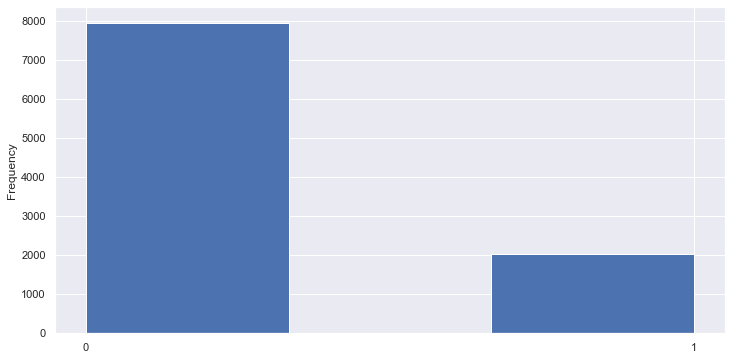

In [16]:
# Plotting our class imbalance
sns.set(rc={'figure.figsize':(12, 6)})
df['Exited'].plot(kind='hist', bins=3)
plt.xticks(ticks=[0,1], labels=[0,1]);

Our Exited column has roughly 4x the number of 0's than 1's. This is an obvious class imbalance and we will focus on improving this.

### Testing setting class weight to balanced

In [17]:
# Our initial F1 Score
print('Initial F1 Score for our best model: {:0.03}'.format(
    f1_score(target_test, RFR_predictions_test)))
print('Initial ROC-AUC Score for our best model: {:0.03}'.format(
    roc_auc_score(target_test, RFR_rfc.predict_proba(features_test)[:, 1])))

Initial F1 Score for our best model: 0.578
Initial ROC-AUC Score for our best model: 0.866


In [18]:
# Checking Confusion Matrix values
confusion_matrix(target_test, RFR_predictions_test)

array([[759,  23],
       [120,  98]], dtype=int64)

In [19]:
model = RandomForestClassifier(**RFR_rfc.best_params_, class_weight='balanced', random_state=123)
model.fit(features_train, target_train)
predicted_balanced = model.predict(features_test)

# F1 Score after balancing, and it's effect on Accuracy Score
print('Balanced F1 Score: {:0.03}'.format(f1_score(target_test, predicted_balanced)))
print('Balanced ROC-AUC: {:0.03}'.format(roc_auc_score(target_test, model.predict_proba(features_test)[:, 1])))

Balanced F1 Score: 0.608
Balanced ROC-AUC: 0.863


In [20]:
# Checking Confusion Matrix values
confusion_matrix(target_test, predicted_balanced)

array([[730,  52],
       [100, 118]], dtype=int64)

Balancing the class weight in our RF Classifier using class_weight='balanced' noticably increases our F1 and our ROC-AUC score slightly lowered.

### Testing Up/Down Sampling

In [21]:
# Downsampling def
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled

In [22]:
# Defining downsampling variables
features_downsampled, target_downsampled = downsample(
    features_train, target_train, 0.2)

# Testing our model with downsampling
model_down = RandomForestClassifier(**RFR_rfc.best_params_, random_state=123)
model_down.fit(features_downsampled, target_downsampled)
predicted_downsampled = model_down.predict(features_test)

print('Downsampled F1 Score: {:0.03}'.format(f1_score(target_test, predicted_downsampled)))
print('Downsampled ROC-AUC: {:0.03}'.format(roc_auc_score(target_test, model_down.predict_proba(features_test)[:, 1])))

Downsampled F1 Score: 0.603
Downsampled ROC-AUC: 0.863


In [23]:
# Upsample def
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

In [24]:
# Defining upsampled variables
features_upsampled, target_upsampled = upsample(
    features_train, target_train, 4
)

# Testing our model with upsampling
model_up = RandomForestClassifier(**RFR_rfc.best_params_, random_state=123)
model_up.fit(features_upsampled, target_upsampled)
predicted_upsampled = model_up.predict(features_test)

print('Upsampled F1 Score: {:0.03}'.format(f1_score(target_test, predicted_upsampled)))
print('Upsampled ROC-AUC: {:0.03}'.format(roc_auc_score(target_test, model_up.predict_proba(features_test)[:, 1])))

Upsampled F1 Score: 0.622
Upsampled ROC-AUC: 0.861


Upsampling is overall more effective in increasing our F1 and ROC-AUC scores.

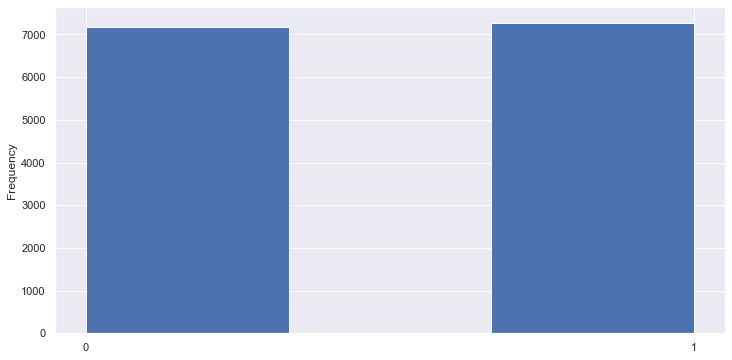

In [25]:
# Plotting our fixed class 'imbalance'
target_upsampled.plot(kind='hist', bins=3)
plt.xticks(ticks=[0,1], labels=[0,1]);

Balancing Class Weight has a noticable impact on the F1 score. We also now have an equal class balance.

### Bringing our improvements together

In [26]:
# Rechecking our scores after RF class balance and Upsampling
model_all = RandomForestClassifier(**RFR_rfc.best_params_, random_state=123, class_weight='balanced')
model_all.fit(features_upsampled, target_upsampled)
predicted_upsampled_new = model_all.predict(features_test)

print('Difference between upsampled and upsampled balanced F1 Score: {:0.03}'.format(
    f1_score(target_test, predicted_upsampled) - f1_score(target_test, predicted_upsampled_new)))
print('Difference between upsampled and upsampled balanced ROC-AUC: {:0.03}'.format(
    roc_auc_score(target_test, model_up.predict_proba(features_test)[:, 1]) - roc_auc_score(target_test, model_all.predict_proba(features_test)[:, 1])))

Difference between upsampled and upsampled balanced F1 Score: 0.00968
Difference between upsampled and upsampled balanced ROC-AUC: 0.001


Using upsampling and class balancing together seem to have a minimal impact on improving or worsening either score. Going forward, we'll just stick with upsampled RF Classifier.

In [27]:
# Sanity check our model accuracy
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(features_train, target_train)
dummy_predict = dummy_model.predict(features_test)

print('Dummy AUC-ROC Score:', roc_auc_score(target_test, dummy_model.predict_proba(features_test)[:, 1]))
print('Model AUC-ROC Score:', f1_score(target_test, predicted_upsampled))

Dummy AUC-ROC Score: 0.5
Model AUC-ROC Score: 0.6219239373601789


Our model's AUC-ROC score passes a sanity check, performing noticably above random chance. Here there's no need to sanity check our F1 score, as a fake model with all 0's will return a F1 score of 0, which isn't very useful.

## Conclusion

In [28]:
print('Final F1 Score: {:0.02}'.format(f1_score(target_test, predicted_upsampled)))
print('Final ROC-AUC: {:0.02}'.format(roc_auc_score(target_test, model_up.predict_proba(features_test)[:, 1])))

Final F1 Score: 0.62
Final ROC-AUC: 0.86


After improving our model and classes we reach our epitome, with an F1 Score over our requirement of 0.59, and AUC-ROC score of about 0.86. There was significantly less 1's in our target column so we used upsampling to fix this. Overall, our model is now passable for Beta Bank customer predictions.